# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pm
from pmdarima import auto_arima

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

import warnings
# Ignore the specific warning
warnings.filterwarnings("ignore")

# 2. Load and Looking Datas

In [2]:
features = pd.read_csv('features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [3]:
stores = pd.read_csv('stores.csv')
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
train = pd.read_csv('train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
test = pd.read_csv('test.csv')
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


# 3. Merge Datas

In [6]:
df = train.merge(stores, on='Store', how='inner').merge(features, on=['Store','Date'], how='inner')
df.rename(columns=str.lower, inplace=True)
print(df.shape)
df.head()

(421570, 17)


,store,dept,date,weekly_sales,isholiday_x,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


# 4. Data Prep

In [7]:
# drop duplicated column
df = df.drop('isholiday_y', axis=1)
df.rename(columns={'isholiday_x':'isholiday'}, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         421570 non-null  int64  
 1   dept          421570 non-null  int64  
 2   date          421570 non-null  object 
 3   weekly_sales  421570 non-null  float64
 4   isholiday     421570 non-null  bool   
 5   type          421570 non-null  object 
 6   size          421570 non-null  int64  
 7   temperature   421570 non-null  float64
 8   fuel_price    421570 non-null  float64
 9   markdown1     150681 non-null  float64
 10  markdown2     111248 non-null  float64
 11  markdown3     137091 non-null  float64
 12  markdown4     134967 non-null  float64
 13  markdown5     151432 non-null  float64
 14  cpi           421570 non-null  float64
 15  unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


## 4.1 set the datatypes and Create datetime features

In [9]:
df['date'] = pd.to_datetime(df['date'])
df['store'] = df['store'].astype('category')
df['dept'] = df['dept'].astype('category')
df['type'] = df['type'].astype('category')

In [10]:
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [11]:
df.head()

,store,dept,date,weekly_sales,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,week,month,year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010


## 4.2 Data Cleaning

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weekly_sales,421570.0,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36
size,421570.0,136727.915739,60980.583328,34875.0,93638.0,140167.0,202505.0,219622.0
temperature,421570.0,60.090059,18.447931,-2.06,46.68,62.09,74.28,100.14
fuel_price,421570.0,3.361027,0.458515,2.472,2.933,3.452,3.738,4.468
markdown1,150681.0,7246.420196,8291.221345,0.27,2240.27,5347.45,9210.9,88646.76
markdown2,111248.0,3334.628621,9475.357325,-265.76,41.6,192.0,1926.94,104519.54
markdown3,137091.0,1439.421384,9623.07829,-29.1,5.08,24.6,103.99,141630.61
markdown4,134967.0,3383.168256,6292.384031,0.22,504.22,1481.31,3595.04,67474.85
markdown5,151432.0,4628.975079,5962.887455,135.16,1878.44,3359.45,5563.8,108519.28
cpi,421570.0,171.201947,39.159276,126.064,132.022667,182.31878,212.416993,227.232807


- In the weekly_sales column you can see that there is a minus value in the minimum value, we will take data that does not contain minus values in the weekly_sales column


### 4.2.1 Drop the Minus Values in weekly_sales column

In [13]:
# checking if there are strange values
df[df['weekly_sales']<=0]

,store,dept,date,weekly_sales,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,week,month,year
188,1,47,2010-02-19,-863.00,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,7,2,2010
406,1,47,2010-03-12,-698.00,False,A,151315,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,10,3,2010
2549,1,47,2010-10-08,-58.00,False,A,151315,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,40,10,2010
3632,1,54,2011-01-21,-50.00,False,A,151315,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,3,1,2011
4132,1,47,2011-03-11,0.00,False,A,151315,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,10,3,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,B,118221,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,21,5,2012
420403,45,49,2012-06-29,-34.00,False,B,118221,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,26,6,2012
420736,45,49,2012-08-03,-1.91,False,B,118221,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,31,8,2012
421007,45,54,2012-08-31,0.00,False,B,118221,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,35,8,2012


In [14]:
df[df['weekly_sales']<=0].shape[0]/df.shape[0] * 100

0.3221291837654482

- there is 0.3% of data that has a minus value in the weekly_sales column

In [15]:
df = df[df['weekly_sales']>0]
print(df.shape)
df.head()

(420212, 19)


,store,dept,date,weekly_sales,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,week,month,year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,2010


### 4.2.2 Fill missing values in markdown columns with 0

#### NaN values in the markdown column indicate there is no markdown on sales

In [16]:
df.isna().sum()/df.shape[0] * 100

store            0.000000
dept             0.000000
date             0.000000
weekly_sales     0.000000
isholiday        0.000000
type             0.000000
size             0.000000
temperature      0.000000
fuel_price       0.000000
markdown1       64.260659
markdown2       73.607608
markdown3       67.480462
markdown4       67.988063
markdown5       64.082654
cpi              0.000000
unemployment     0.000000
week             0.000000
month            0.000000
year             0.000000
dtype: float64

In [17]:
df = df.fillna(0)
df.isna().sum()

store           0
dept            0
date            0
weekly_sales    0
isholiday       0
type            0
size            0
temperature     0
fuel_price      0
markdown1       0
markdown2       0
markdown3       0
markdown4       0
markdown5       0
cpi             0
unemployment    0
week            0
month           0
year            0
dtype: int64

## 4.3 set date as index

In [18]:
df = df.set_index('date')
df.head()

,store,dept,weekly_sales,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,week,month,year
date,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010
2010-02-05,1,2,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010
2010-02-05,1,3,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010
2010-02-05,1,4,39954.04,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010
2010-02-05,1,5,32229.38,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010


# 5. Exploring Data

### 5.1 How many stores, departments and store types are in the dataset?

- There are 45 stores, 81 departments, and 3 store type

In [19]:
print('Total Store : ',df['store'].nunique())
print('Total Department : ',df['dept'].nunique())
print('Number of Store Type : ',df['type'].nunique())

Total Store :  45
Total Department :  81
Number of Store Type :  3


### 5.2 What first and last date the data was recorded in the dataset?
- This datset record weekly_sales of Walmart from 5 February 2010 until 26 October 2012
- There are 48 weeks in 2010, 52 weeks in 2011, and 43 weeks in 2012

In [20]:
print('Date start in',df.index.min(), 'and end in',df.index.max())

Date start in 2010-02-05 00:00:00 and end in 2012-10-26 00:00:00


In [21]:
df.groupby('year')['week'].nunique()

year
2010    48
2011    52
2012    43
Name: week, dtype: int64

### 5.3 Which store got the most weekly sales ?
- Store 20 is the best store which got highest weekly_sales with 301.4 M followed by store 4 and 14 in the second and third
- store 5, 44. and 33 are the bottom 3 in getting weekly_sales

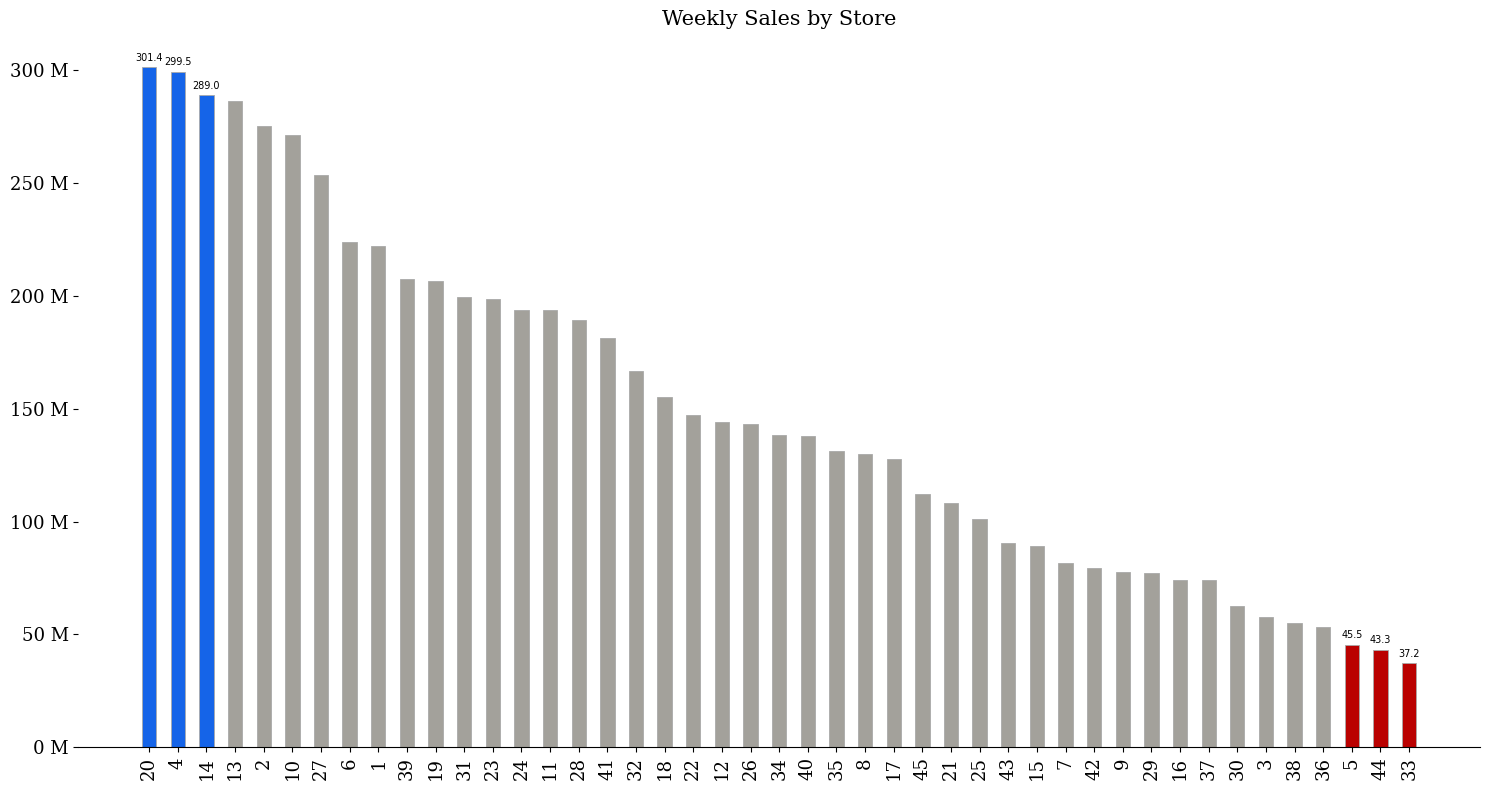

In [22]:
store_sales = df.groupby('store')['weekly_sales'].sum().sort_values(ascending=False)/1000000

color_map = ['#a3a19b' for _ in range(len(store_sales))]
color_map[:3] = ['#1564e8','#1564e8','#1564e8']
color_map[-3:] = ['#ba0100','#ba0100','#ba0100']

fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar([str(idx) for idx in store_sales.index], store_sales, width=0.5, edgecolor='darkgray', linewidth=0.6, color=color_map)

def millions(x, pos):
    return f'{x:.0f} M'

ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Remove border from plot
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# add annotation for top 3 and bottom 3
top_bottom_bars = bars[:3] + bars[-3:]
top_bottom_sales = store_sales[:3].append(store_sales[-3:])
for i, (bar, sale) in enumerate(zip(top_bottom_bars, top_bottom_sales)):
    height = bar.get_height() + 2
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{sale:.1f}',
            ha='center', va='bottom', fontsize=7, color='black')
    
plt.xticks(fontfamily='serif', fontsize=13, rotation=90)
plt.yticks(fontfamily='serif', fontsize=13)
plt.title('Weekly Sales by Store',fontfamily='serif', fontsize=15)

plt.tight_layout()
plt.show()

### 5.4 Which department got the most weekly sales?
- Department 92 is the best department in getting weekly_sales througout timeseries in this dataset with 483.8 M

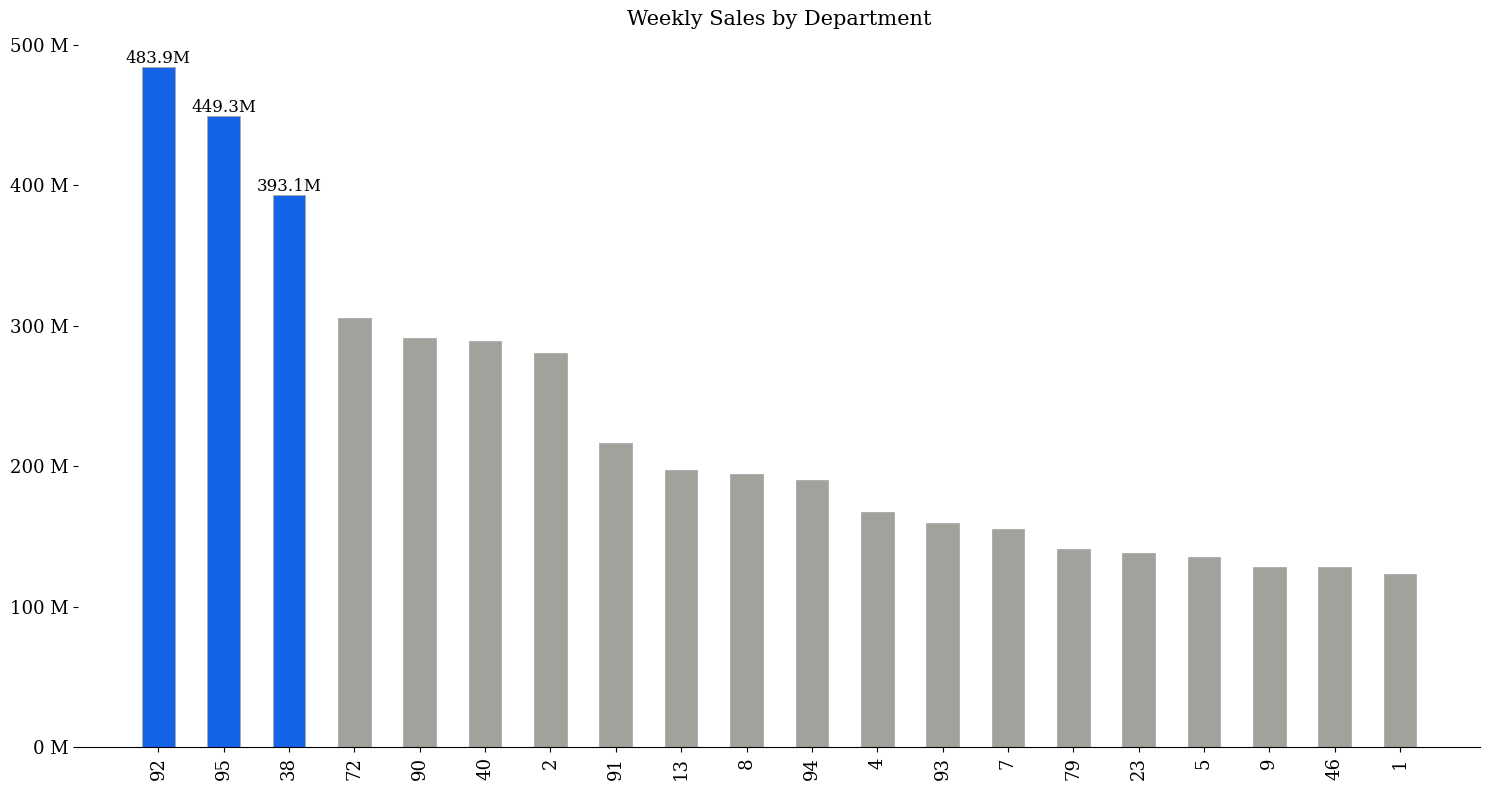

In [23]:
dept_sales = (df.groupby('dept')['weekly_sales'].sum().sort_values(ascending=False)/1000000)[:20]

color_map = ['#a3a19b' for _ in range(len(dept_sales))]
color_map[:3] = ['#1564e8','#1564e8','#1564e8']

fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar([str(idx) for idx in dept_sales.index], dept_sales, width=0.5, edgecolor='darkgray', linewidth=0.6, color=color_map)

def millions(x, pos):
    return f'{x:.0f} M'

ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Remove border from plot
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# add annotation for top 3
for i, bar in enumerate(bars[:3]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}M',
            ha='center', va='bottom', fontsize=12, color='black', fontfamily='serif')
    
plt.xticks(fontfamily='serif', fontsize=13, rotation=90)
plt.yticks(fontfamily='serif', fontsize=13)
plt.title('Weekly Sales by Department',fontfamily='serif', fontsize=15)
plt.tight_layout()
plt.show()

### 5.5 Weekly sales based on the date element
- Weekly sales by year show that 2010 was the best year with 16318 in average.
- Weekly sales by month show that December was the best month with 19425 in average, this can be expected because December is a holiday where people will be more inclined to shop.
- In the Monthly sales line plot, it is evident that sales follow a consistent pattern every year, with sales consistently increasing in November and December. This trend is observable year after year.
- The weekly sales line plot indicates a consistent pattern in sales each year, with peak sales occurring in the 50th week.

In [24]:
df.groupby('year')['weekly_sales'].mean()

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: weekly_sales, dtype: float64

In [25]:
df.groupby('month')['weekly_sales'].mean().sort_values(ascending=False)

month
12    19425.798603
11    17534.964277
6     16397.605478
8     16113.800069
2     16048.701191
7     15905.472425
5     15845.556200
4     15696.435193
3     15464.817698
10    15279.182119
9     15147.216063
1     14182.239153
Name: weekly_sales, dtype: float64

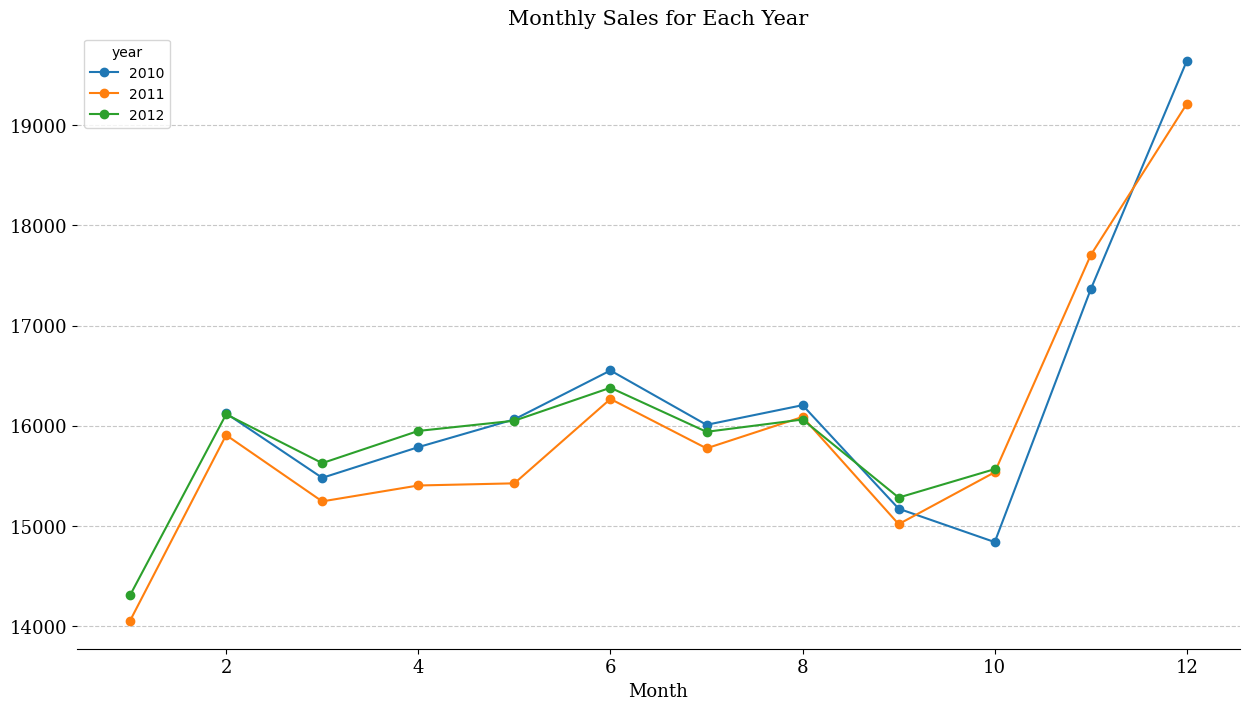

In [26]:
monthly_sales = pd.pivot_table(df, values = 'weekly_sales', columns = 'year', index = 'month') # sales trend for each year

fig, ax = plt.subplots(figsize=(15,8))

monthly_sales.plot(figsize=(15,8), lw=1.5, ax=ax, marker='o')

# Remove border from plot
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Monthly Sales for Each Year', fontfamily='serif', fontsize=15)
plt.xlabel('Month',fontfamily='serif', fontsize=13)
plt.xticks(fontfamily='serif', fontsize=13)
plt.yticks(fontfamily='serif', fontsize=13)
plt.show()

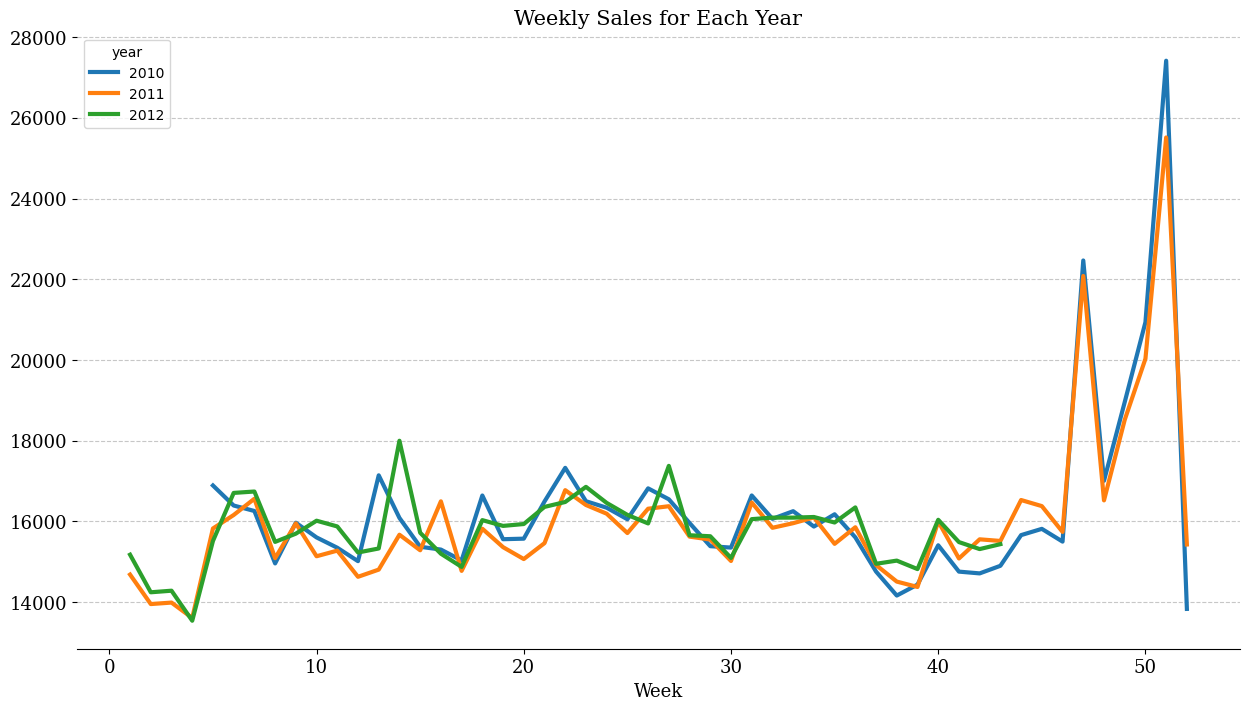

In [27]:
weekly_sales = pd.pivot_table(df, values = 'weekly_sales', columns = 'year', index = 'week') # sales trend for each year

fig, ax = plt.subplots(figsize=(15,8))

weekly_sales.plot(figsize=(15,8), lw=3, ax=ax)

# Remove border from plot
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Weekly Sales for Each Year', fontfamily='serif', fontsize=15)
plt.xlabel('Week',fontfamily='serif', fontsize=13)
plt.xticks(fontfamily='serif', fontsize=13)
plt.yticks(fontfamily='serif', fontsize=13)

plt.show()

### 5.6 Weekly Sales based on whether it is a holiday or not
- Average weekly sales on holidays are higher with 51.7% compared to non-holidays with 48.3%
- Thanksgiving sales consistently surpass another holiday sales, with an average of 22,269. This demonstrates the popularity and demand for Thanksgiving products over another holiday.

In [28]:
sales_by_holiday = df.groupby('isholiday')['weekly_sales'].mean().reset_index()
sales_by_holiday

,isholiday,weekly_sales
0,False,15952.816352
1,True,17094.300918


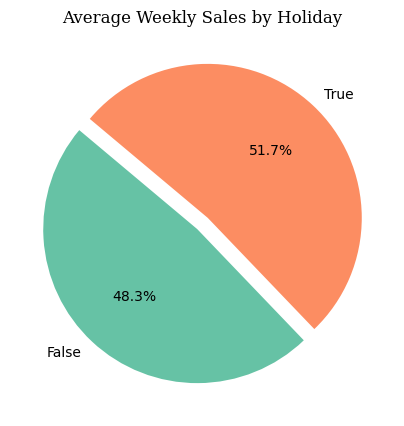

In [29]:
plt.figure(figsize=(5, 5))
sns.set_palette('Set2')
explode = [0.05] * len(sales_by_holiday)
plt.pie(sales_by_holiday['weekly_sales'], labels=sales_by_holiday['isholiday'],
        autopct='%1.1f%%', startangle=140, explode=explode)

plt.title('Average Weekly Sales by Holiday', fontfamily='serif')
plt.show()

In [30]:
sales_by_date = df.groupby(['year','month','week','isholiday'])[['weekly_sales']].mean().reset_index()
sales_by_date.head()

,year,month,week,isholiday,weekly_sales
0,2010,2,5,False,16887.602166
1,2010,2,6,True,16390.912208
2,2010,2,7,False,16255.185970
3,2010,2,8,False,14955.932194
4,2010,3,9,False,15964.821240


In [31]:
sales_by_date[sales_by_date['isholiday']==True]

,year,month,week,isholiday,weekly_sales
1,2010,2,6,True,16390.912208
31,2010,9,36,True,15601.852533
42,2010,11,47,True,22464.578928
47,2010,12,52,True,13828.570595
53,2011,2,6,True,16155.910205
83,2011,9,36,True,15852.122176
94,2011,11,47,True,22080.184300
99,2011,12,52,True,15425.226436
105,2012,2,6,True,16703.472478
135,2012,9,36,True,16344.419692


In [32]:
df['whats_holiday'] = 'Not holiday'  # create column 'whats_holiday' with the value 'Not holiday'

# apply conditions for 'whats_holiday' column
df.loc[df['week'] == 6, 'whats_holiday'] = 'super bowl'
df.loc[df['week'] == 36, 'whats_holiday'] = 'labor day'
df.loc[df['week'] == 47, 'whats_holiday'] = 'thanks giving'
df.loc[df['week'] == 52, 'whats_holiday'] = 'christmas'
df.head()

,store,dept,weekly_sales,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,week,month,year,whats_holiday
date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010,Not holiday
2010-02-05,1,2,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010,Not holiday
2010-02-05,1,3,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010,Not holiday
2010-02-05,1,4,39954.04,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010,Not holiday
2010-02-05,1,5,32229.38,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010,Not holiday


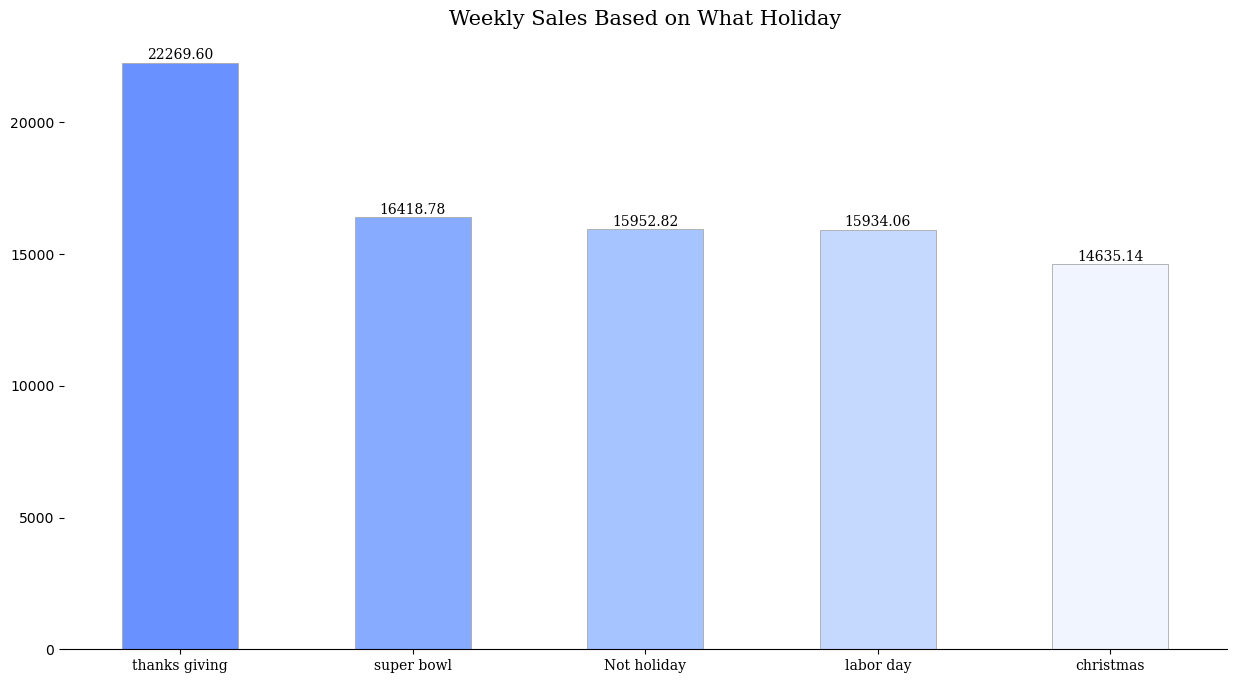

In [33]:
colors = ['#6991ff', '#87abff', '#a6c4ff', '#c5d9ff', '#f0f5ff']
fig, ax = plt.subplots(figsize=(15, 8))

bars = (df.groupby('whats_holiday')['weekly_sales'].mean().sort_values(ascending=False))\
                                    .plot(kind='bar', ax=ax, width=0.5, edgecolor='darkgray', linewidth=0.6, color=colors)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Annotate each bar with its value
for i, bar in enumerate(bars.patches):
    # Get the height of the bar
    height = bar.get_height()
    # Add text annotation above each bar with its value formatted to two decimal places
    ax.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{height:.2f}', ha='center', va='bottom', 
            fontfamily='serif', fontsize=10, color='black')

plt.xticks(rotation=0, fontfamily='serif')
plt.xlabel('')
plt.title('Weekly Sales Based on What Holiday', fontfamily='serif', fontsize=15)
plt.show()

### 5.7 Weekly Sales based on Store Type
- Weekly sales in types A and B have almost the same pattern, but in type A the weekly sales are higher than in type B, while in type C the number of sales is the smallest compared to types A and B
- The highest sales for types A and B occurred at Thanksgiving, while for type C the largest sales occurred at the Superbowl

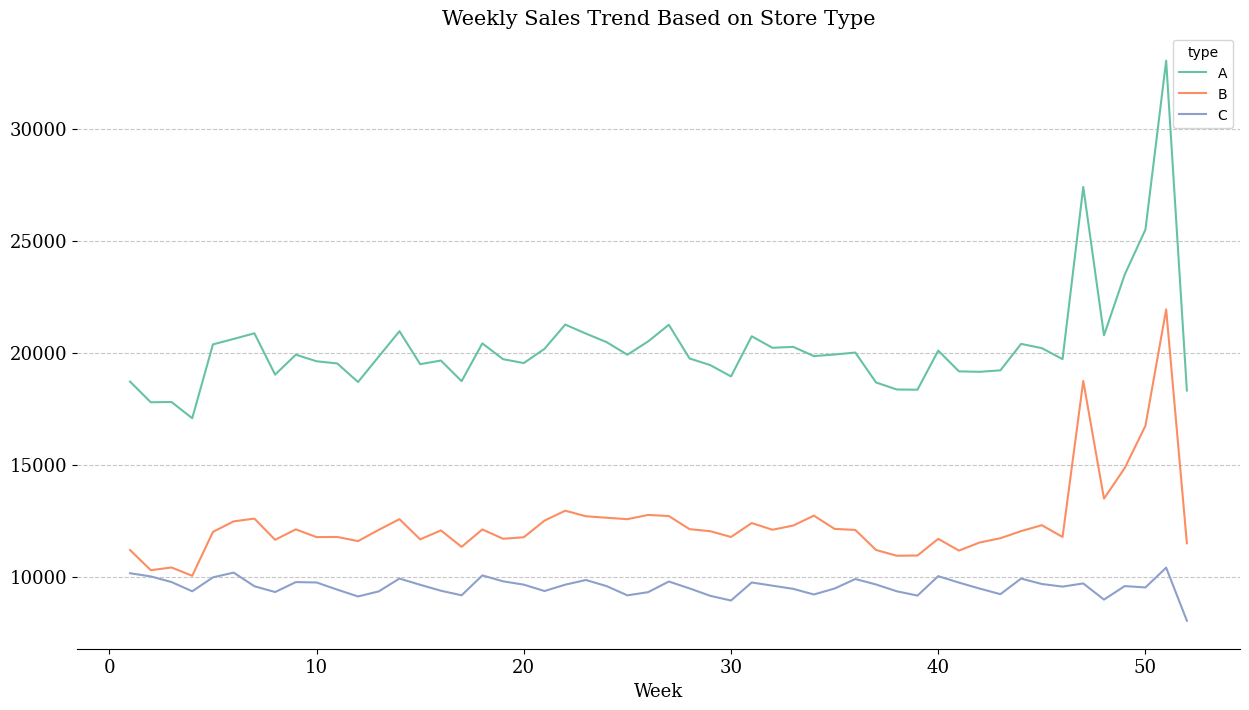

In [34]:
fig, ax = plt.subplots()
pd.pivot_table(df, values='weekly_sales', index='week', columns='type').plot(figsize=(15,8), ax=ax)

# Remove border from plot
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Weekly Sales Trend Based on Store Type', fontfamily='serif', fontsize=15)
plt.xlabel('Week',fontfamily='serif', fontsize=13)
plt.xticks(fontfamily='serif', fontsize=13)
plt.yticks(fontfamily='serif', fontsize=13)

plt.show()

In [35]:
holiday_type_sales = df.groupby(['whats_holiday','type'])['weekly_sales'].mean().reset_index()
holiday_type_sales

,whats_holiday,type,weekly_sales
0,Not holiday,A,20058.212098
1,Not holiday,B,12204.870740
2,Not holiday,C,9548.251972
3,christmas,A,18310.167535
4,christmas,B,11488.988057
5,christmas,C,8031.520607
6,labor day,A,20004.267422
7,labor day,B,12084.304642
8,labor day,C,9893.459258
9,super bowl,A,20612.757674


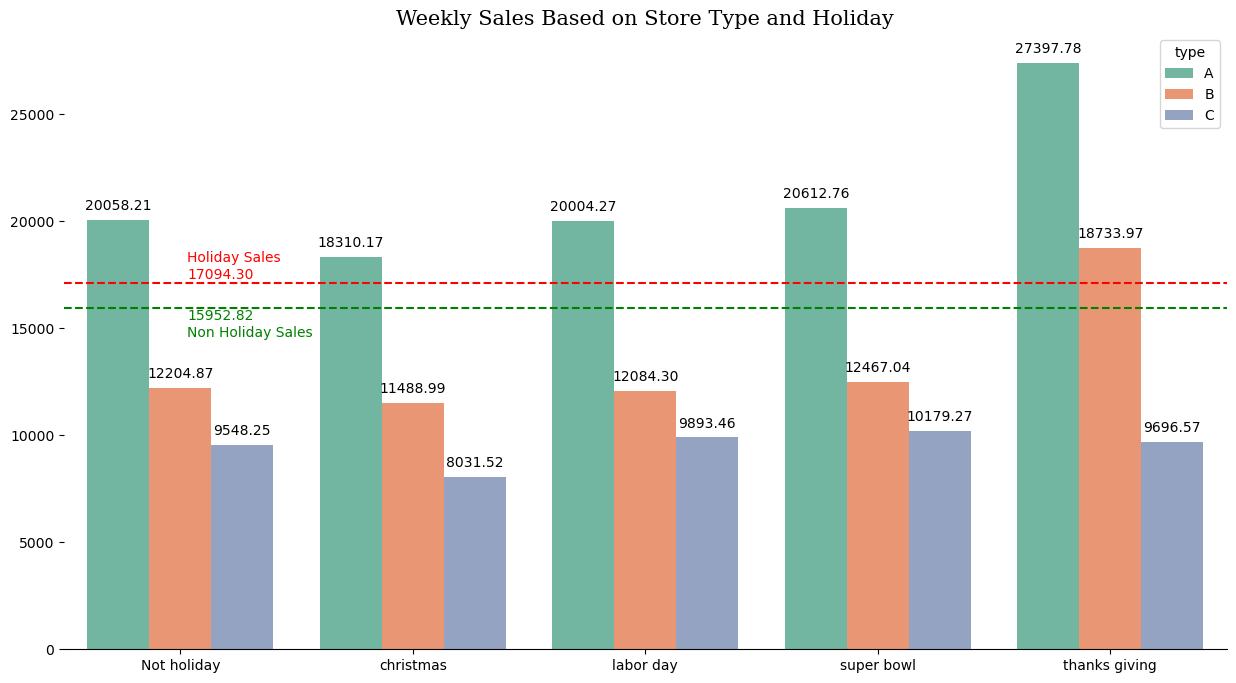

In [36]:
fig, ax = plt.subplots(figsize=(15,8))

sns.barplot(x='whats_holiday', y='weekly_sales', hue='type', data=holiday_type_sales, ax=ax)

# Remove border from plot
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add Annotation
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Add axhline for holiday sales mean and non holiday sales mean
holiday_sales_mean = df[df['isholiday']==True]['weekly_sales'].mean()
non_holiday_sales_mean = df[df['isholiday']==False]['weekly_sales'].mean()

ax.axhline(holiday_sales_mean, color='r', ls='--')
ax.annotate(f'Holiday Sales\n{holiday_sales_mean:.2f}', 
            xy=(0, holiday_sales_mean), 
            xytext=(5, 23), 
            textcoords='offset points', 
            ha='left', 
            va='top', 
            color='r')

ax.axhline(non_holiday_sales_mean, color='g', ls='--')
ax.annotate(f'{non_holiday_sales_mean:.2f}\nNon Holiday Sales', 
            xy=(0, non_holiday_sales_mean), 
            xytext=(5, -23), 
            textcoords='offset points', 
            ha='left', 
            va='bottom', 
            color='g')

plt.title('Weekly Sales Based on Store Type and Holiday', fontfamily='serif', fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.show()

# 6. Time Series Analysis

### 6.1 Resampling and Looking sales pattern

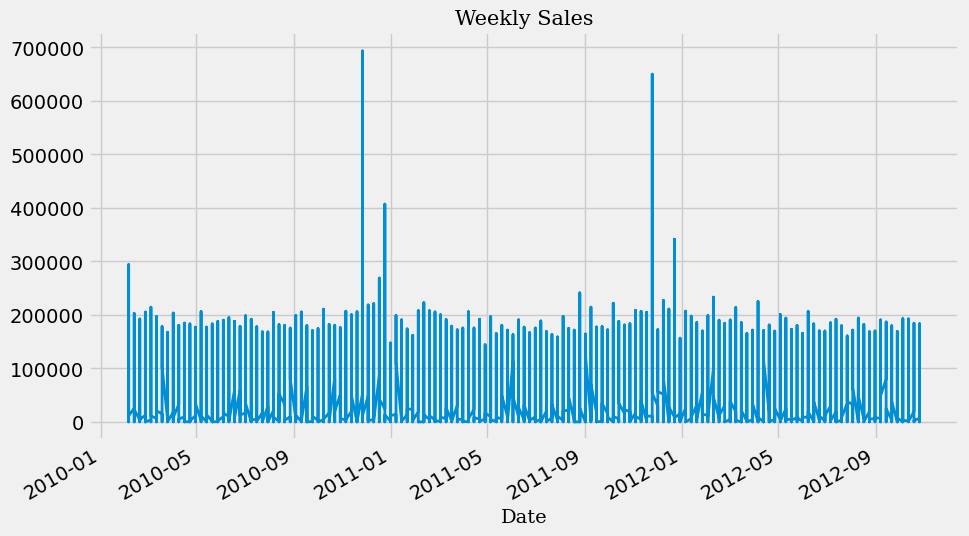

In [37]:
# Original data without resampling
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
df['weekly_sales'].plot(lw=2)

plt.title('Weekly Sales', fontfamily='serif', fontsize=15)
plt.xlabel('Date', fontfamily='serif')
plt.show()

- Because there was too much data, we did resampling to see the pattern more clearly

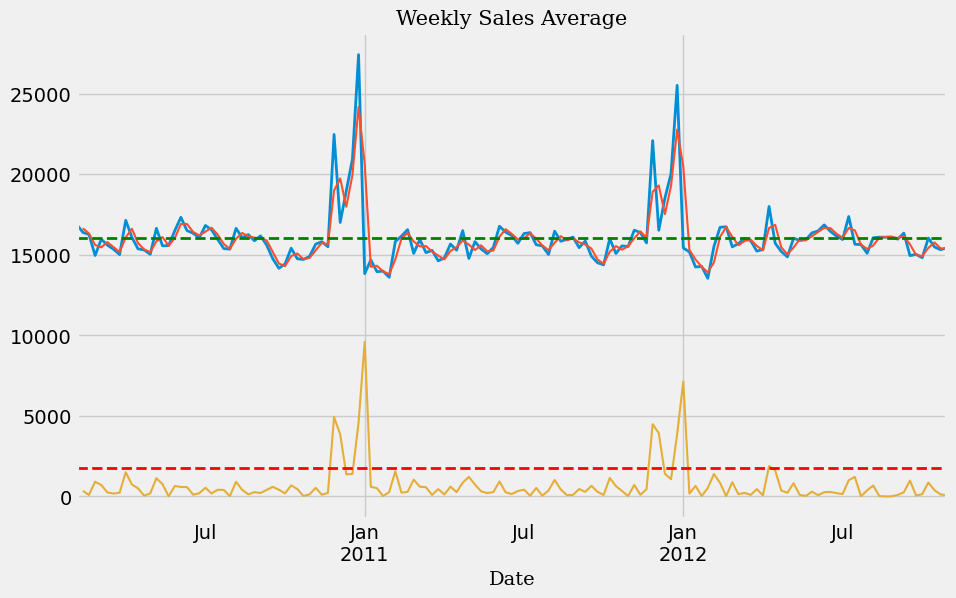

In [38]:
# weekly resample
weekly_df = df.resample('W').mean()

plt.style.use('fivethirtyeight')

fig,ax = plt.subplots(figsize=(10, 6))

weekly_df['weekly_sales'].plot(lw=2, ax=ax)
weekly_df['weekly_sales'].rolling(2).mean().plot(lw=1.5, ax=ax)
weekly_df['weekly_sales'].rolling(2).std().plot(lw=1.5, ax=ax)

ax.axhline(weekly_df['weekly_sales'].mean(), color='green', linestyle='--', linewidth=2)
ax.axhline(weekly_df['weekly_sales'].std(), color='red', linestyle='--', linewidth=2)

plt.title('Weekly Sales Average', fontfamily='serif', fontsize=15)
plt.xlabel('Date', fontfamily='serif')
plt.show()

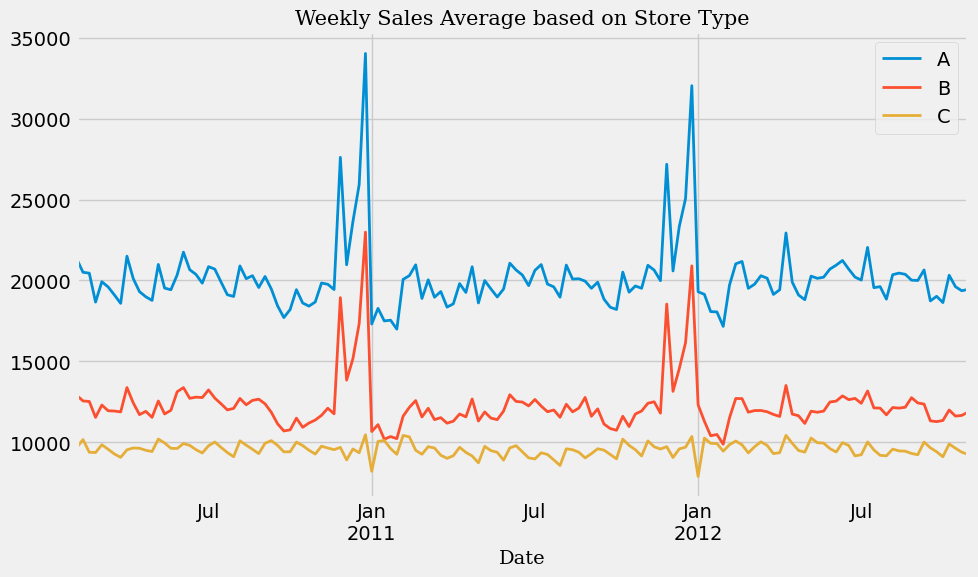

In [39]:
# weekly resampling and store type
plt.figure(figsize=(10, 6))

for t in df['type'].unique():
    df[df['type']==t]['weekly_sales'].resample('W').mean().plot(lw=2)

plt.title(f'Weekly Sales Average based on Store Type', fontfamily='serif', fontsize=15)
plt.xlabel('Date', fontfamily='serif')
plt.legend(df['type'].unique())
        
plt.tight_layout()
plt.show()

#### Conclusions:
- In original data without resampling, it is difficult to see in detail the patterns in the data
- Looking at the line plot after weekly resampling, we can see the patterns that occur along the dates in the data
- Store types A and B have almost the same pattern but with different sales levels
- Based on the moving average line, it can be seen that the data is looking stationary, we will carry out a statistical test to see stationarity

### 6.2 Stationary Test 

In [40]:
result = adfuller(weekly_df['weekly_sales'])
print(f'Weekly Sales ADF-Stat: {round(result[0],2)} and p-value: {result[1]}')
    
if result[1] > 0.05:
    print(f'Weekly Sales not stationary, need differencing.')
else:
    print(f"Weekly Sales stationary, doesn't need differencing.")    

Weekly Sales ADF-Stat: -5.93 and p-value: 2.4290492082042356e-07
Weekly Sales stationary, doesn't need differencing.


### 6.3 Decomposition

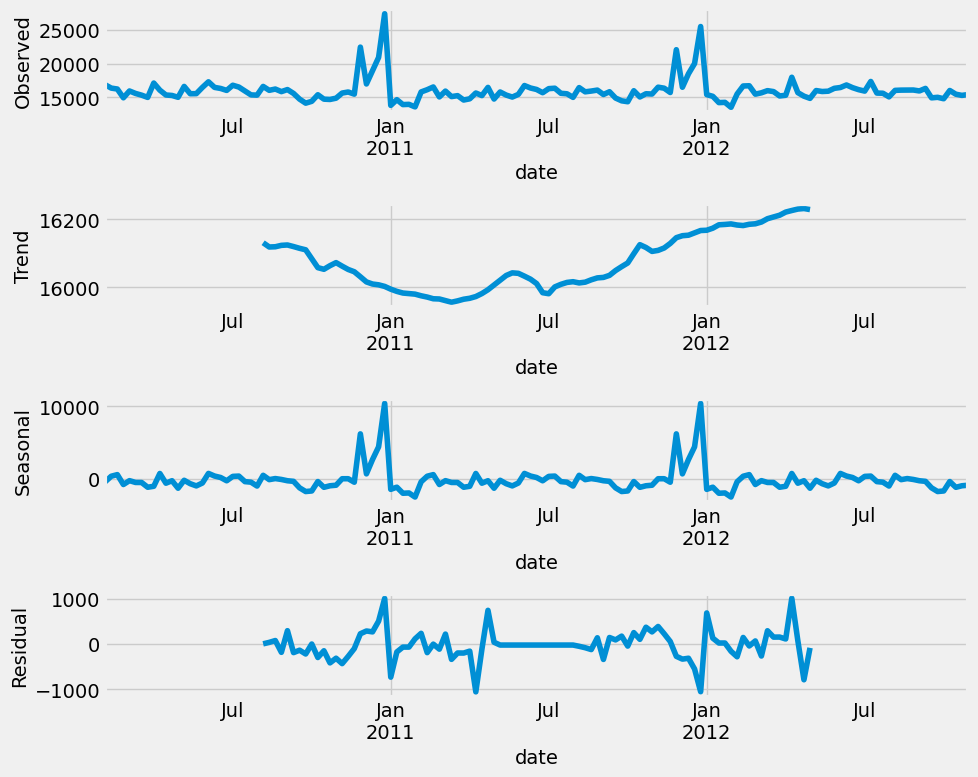

In [41]:
decomp = seasonal_decompose(weekly_df['weekly_sales'], 
                            period=52)

fig, ax = plt.subplots(4, 1, figsize=(10, 8))

decomp.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')

decomp.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

decomp.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('Seasonal')

decomp.resid.plot(ax=ax[3])
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### 6.4 ACF & PACF plot

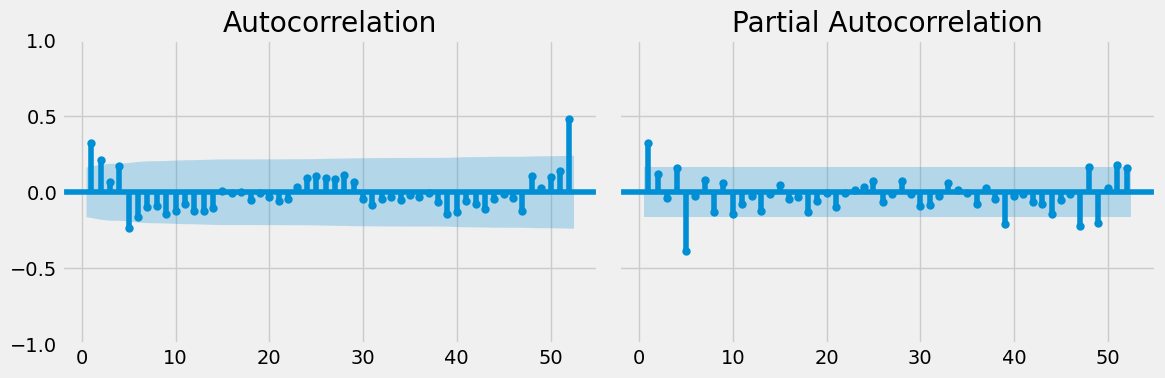

In [42]:
fig, ax = plt.subplots(ncols= 2, figsize=(12, 4), sharey=True)

plot_acf(weekly_df['weekly_sales'], ax=ax[0], lags=52, zero=False)  # ACF plot in the first column
plot_pacf(weekly_df['weekly_sales'], ax=ax[1], lags=52, zero=False, method='ywm')  # PACF plot in the second column

plt.tight_layout()
plt.show()

- After seeing and observing the results of the seasonal decomposition plotting and patterns in the data as well as the ACF plot, we came to the conclusion that the seasonal pattern occurs in 52 weeks or one year.

### 6.5 Split data

In [43]:
print(len(weekly_df)) # length of weekly_df
print(int(0.7*(len(weekly_df)))) # 70% train split

143
100


In [44]:
train_data = weekly_df[:int(0.7*(len(weekly_df)))] 
test_data = weekly_df[int(0.7*(len(weekly_df))):]

### 6.6 Modelling

In [45]:
# find the order of AR and MA
order_aic_bic = []

for p in range(2):
    for q in range(2):
        for d in range(2):
            for P in range(2):
                for Q in range(2):
                    for D in range(2):
                        model = SARIMAX(train_data['weekly_sales'], order=(p,d,q), seasonal_order=(P,D,Q,52))
                        results = model.fit()
        
                        # Append order and results tuple
                        order_aic_bic.append((p,d,q,P,D,Q,results.aic, results.bic))

order_df = pd.DataFrame(order_aic_bic, columns=['p','d','q','P','D','Q','aic','bic'])

display(order_df.sort_values('aic').head())
display(order_df.sort_values('bic').head())

,p,d,q,P,D,Q,aic,bic
61,1,1,1,1,1,0,738.440365,745.840955
29,0,1,1,1,1,0,738.452035,744.002478
27,0,1,1,0,1,1,738.768953,744.319396
59,1,1,1,0,1,1,738.885082,746.285672
63,1,1,1,1,1,1,740.431889,749.682627


,p,d,q,P,D,Q,aic,bic
29,0,1,1,1,1,0,738.452035,744.002478
27,0,1,1,0,1,1,738.768953,744.319396
61,1,1,1,1,1,0,738.440365,745.840955
59,1,1,1,0,1,1,738.885082,746.285672
45,1,1,0,1,1,0,741.397359,746.947802


In [46]:
import itertools

# Determine values of p, d, q, P, D, Q, m
p = d = q = range(2)
P = D = Q = range(2)
m = 52  # seasonal period

best_aic = float("inf")
best_order = None

# Find the best combination for the best model
for param in itertools.product(p, d, q, P, D, Q):
    try:
        model = SARIMAX(train_data['weekly_sales'], order=param[:3], seasonal_order=param[3:] + (m,))
        results = model.fit()
        aic = results.aic

        if aic < best_aic:
            best_aic = aic
            best_order = param

    except:
        continue

print(f"Best AIC: {best_aic}")
print(f"Best Order: {best_order}")

Best AIC: 738.4403645568273
Best Order: (1, 1, 1, 1, 1, 0)


In [47]:
# Create a SARIMA model
model = SARIMAX(train_data['weekly_sales'], order=(1,1,1), seasonal_order=(1,1,0,52))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        weekly_sales   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                -365.220
Date:                             Wed, 03 Jan 2024   AIC                            738.440
Time:                                     07:03:21   BIC                            745.841
Sample:                                 02-07-2010   HQIC                           741.225
                                      - 01-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3324      0.150      2.215      0.027       0.038       0.627
ma.L1         -0.8019      

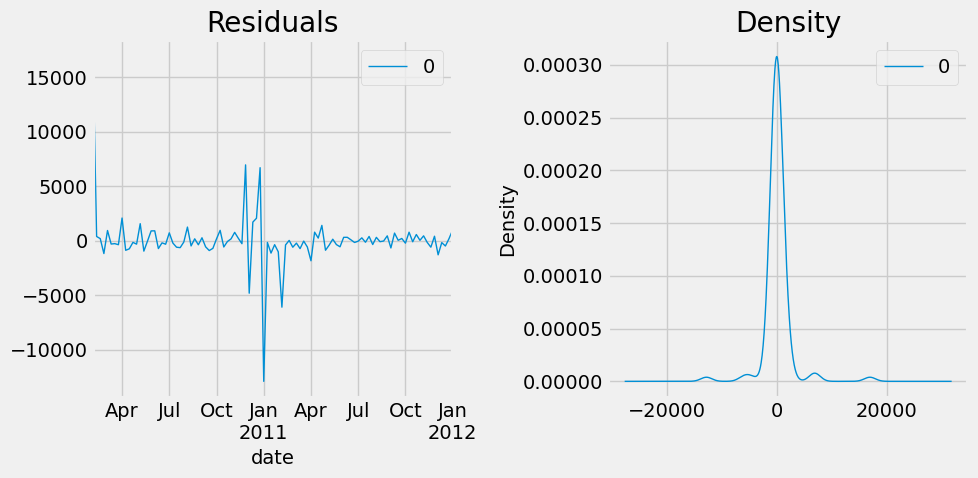

In [48]:
# Plotting the Residual
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2, figsize=(10,5))
residuals.plot(title="Residuals", ax=ax[0], linewidth=1)
residuals.plot(kind='kde', title='Density', ax=ax[1], linewidth=1)
plt.tight_layout()
plt.show()

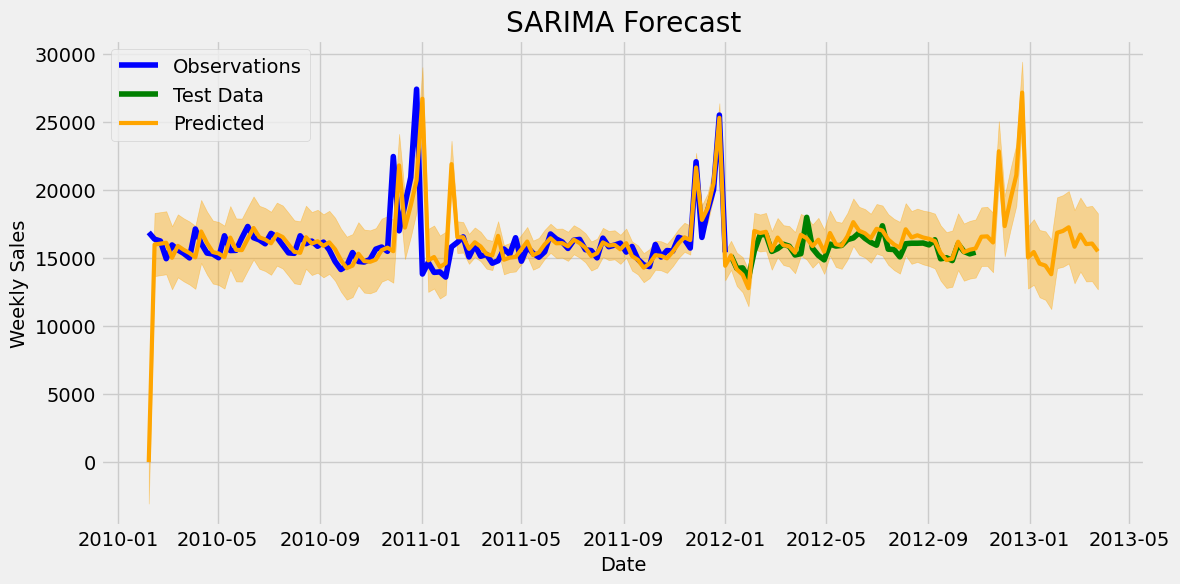

In [62]:
# Prediction and Forecasting
pred = results.get_prediction(start=0, end=len(weekly_df)+20, dynamic=False)

# take the prediction value and the confidence interval
pred_mean = pred.predicted_mean
pred_conf_int = pred.conf_int()

plt.figure(figsize=(12,6))

# Plot observed data
plt.plot(train_data.index, train_data['weekly_sales'], label='Observations', color='blue')
plt.plot(test_data.index, test_data['weekly_sales'], label='Test Data', color='green')


# Plotting prediction
plt.plot(pred_mean.index, pred_mean.values, lw=3, label='Predicted', color='orange')

# Plotting interval prediction
plt.fill_between(pred_conf_int.index, pred_conf_int.iloc[:, 0], pred_conf_int.iloc[:, 1], color='orange', alpha=0.4)

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('SARIMA Forecast')

plt.legend()
plt.show()

In [50]:
# MAE
mae_train = mean_absolute_error(train_data['weekly_sales'], pred_mean[:100])

# RMSE
mse_train = mean_squared_error(train_data['weekly_sales'], pred_mean[:100])
rmse_train = np.sqrt(mse_train)

# MAPE
mape_train = np.mean(np.abs((train_data['weekly_sales'] - pred_mean[:100]) /train_data['weekly_sales'])) * 100

print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_train}")

Mean Absolute Error (MAE): 1043.922575390938
Root Mean Squared Error (RMSE): 2551.205680407161
Mean Absolute Percentage Error (MAPE): 6.280337335193549


In [51]:
# MAE
mae_test = mean_absolute_error(test_data['weekly_sales'], pred_mean[100:143])

# RMSE
mse_test = mean_squared_error(test_data['weekly_sales'], pred_mean[100:143])
rmse_test = np.sqrt(mse_test)

# MAPE
mape_test = np.mean(np.abs((test_data['weekly_sales'] - pred_mean[100:143]) /test_data['weekly_sales'])) * 100

print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test}")

Mean Absolute Error (MAE): 469.54890093103177
Root Mean Squared Error (RMSE): 633.212300960331
Mean Absolute Percentage Error (MAPE): 2.979802220018467


#### After finding the best order for the SARIMA model, we try to predict on the original data and obtain the following conclusions:
- the best order for our SARIMA model is (1,1,1)(1,1,0)52 
- The SARIMA forecast image shows that the model is able to make fairly good predictions on training data. This is also shown in the MAPE score of 6.3
- While in test_data, the prediction in the image shows good results with a better MAPE score compared to train_data with 2.97

### 6.7 Auto-ARIMA

In [52]:
# auto_arima for searching the best fit
model = auto_arima(train_data['weekly_sales'], seasonal=True, m=52,  # Sesuaikan nilai m sesuai periode musiman Anda
                   start_p=0, max_p=2,  # Rentang nilai p yang ingin dijelajahi
                   start_d=0, max_d=2,  # Rentang nilai d yang ingin dijelajahi
                   start_q=0, max_q=2,  # Rentang nilai q yang ingin dijelajahi
                   start_P=0, max_P=2,  # Rentang nilai P yang ingin dijelajahi
                   start_D=0, max_D=2,  # Rentang nilai D yang ingin dijelajahi
                   start_Q=0, max_Q=2,  # Rentang nilai Q yang ingin dijelajahi
                   trace=True,  # Untuk melihat output langkah demi langkah
                   error_action='ignore',  # Untuk menangani kesalahan
                   suppress_warnings=True,  # Untuk mengurangi pesan peringatan
                   stepwise=True)  # Untuk mencari secara langkah-demi-langkah

# Show the summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1813.025, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1790.971, Time=0.67 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2225.311, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1804.632, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=1786.941, Time=1.86 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=1781.317, Time=0.48 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=inf, Time=6.03 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=8.53 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=1791.110, Time=0.29 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=1780.072, Time=0.61 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=inf, T

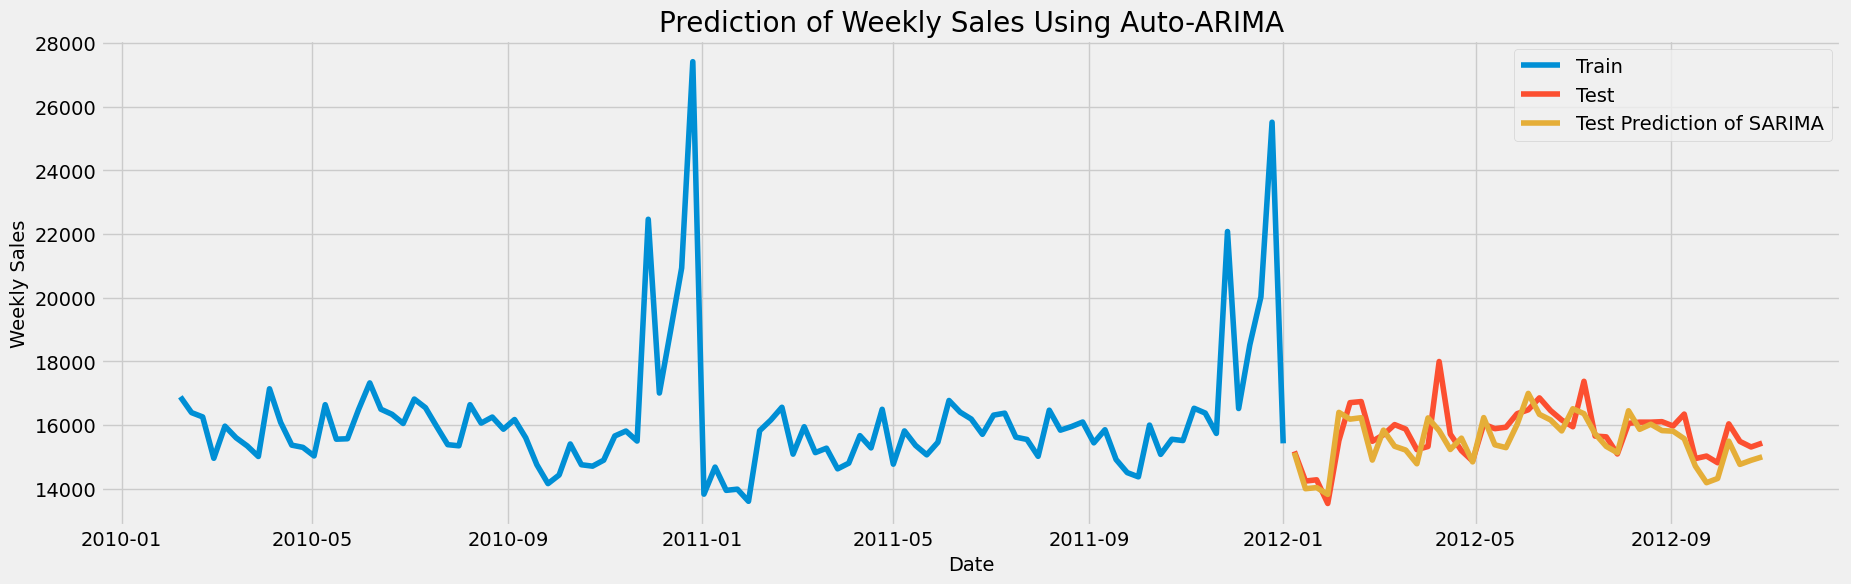

In [53]:
pred_test = model.predict(n_periods=len(test_data))
pred_test = pd.DataFrame(pred_test,index = test_data.index,columns=['Prediction'])

plt.figure(figsize=(20,6))

plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)

plt.plot(train_data['weekly_sales'], label='Train')
plt.plot(test_data['weekly_sales'], label='Test')

plt.plot(pred_test, label='Test Prediction of SARIMA')

plt.legend(loc='best')

plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [54]:
# MAE
mae_test = mean_absolute_error(test_data['weekly_sales'], pred_test)

# RMSE
mse_test = mean_squared_error(test_data['weekly_sales'], pred_test)
rmse_test = np.sqrt(mse_test)

# MAPE
mape_test = np.mean(np.abs((test_data['weekly_sales'].values - pred_test.values) /test_data['weekly_sales'].values)) * 100

print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test}")

Mean Absolute Error (MAE): 468.6936949587002
Root Mean Squared Error (RMSE): 590.4863254881296
Mean Absolute Percentage Error (MAPE): 5.613968436560548


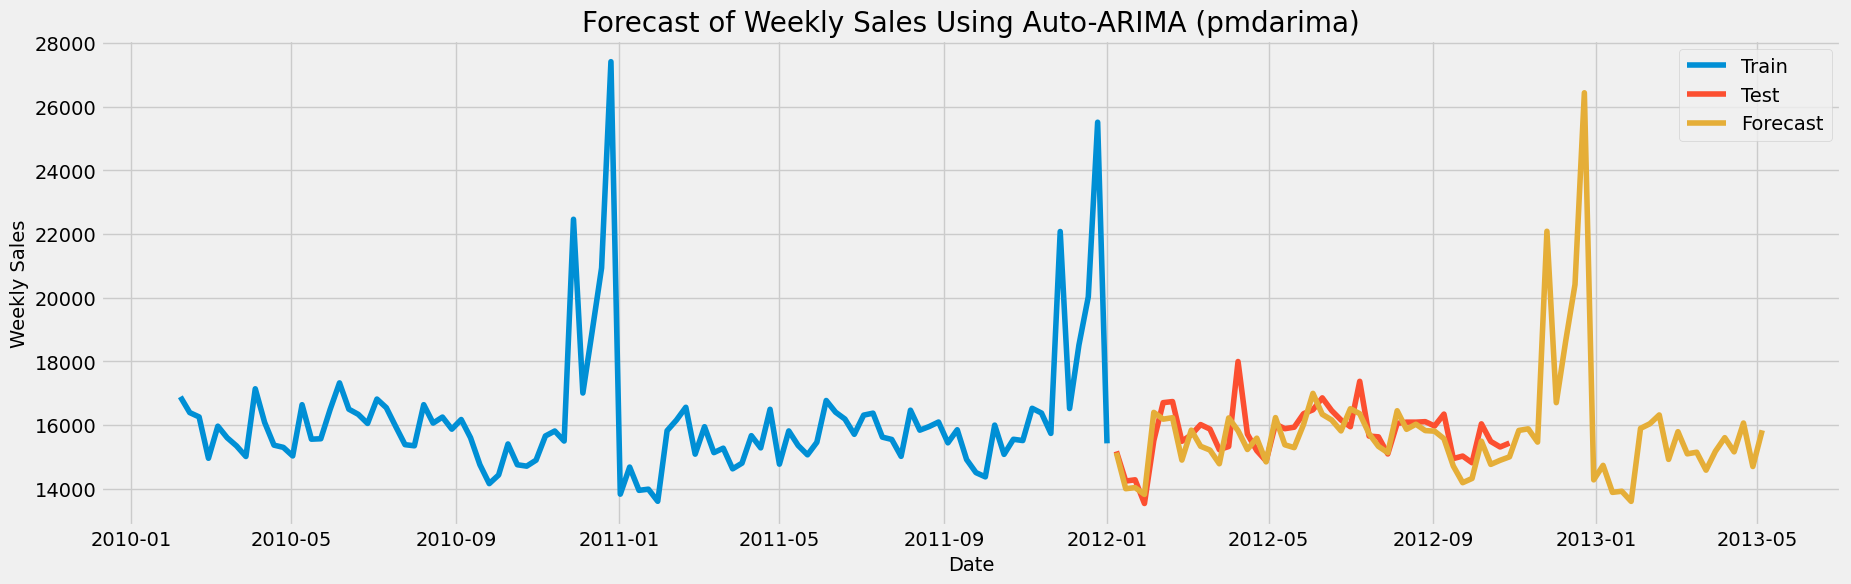

In [55]:
# Make Prediction/Forecasting
data = train_data['weekly_sales'].interpolate(method='linear')
model.fit(data)
forecast = model.predict(n_periods=70)

# Create DataFrame
forecast_index = pd.date_range(start=train_data.index[-1], periods=71, freq='W')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# Plotting Prediction
plt.figure(figsize=(20, 6))
plt.plot(train_data['weekly_sales'], label='Train')
plt.plot(test_data['weekly_sales'], label='Test')
plt.plot(forecast_df, label='Forecast')

plt.title('Forecast of Weekly Sales Using Auto-ARIMA (pmdarima)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.legend()
plt.show()

#### We do modeling using auto-arima and get the following conclusions:
- in the auto ARIMA model shows that the order for the best model is (1,0,2)(2,0,0)[52]
- The data depicted in the graph indicates that the prediction aligns well with the testing data, as evidenced by the MAPE score of 5.61. This suggests that the model's accuracy is reliable and consistent.